                  date symbol        open       close         low        high  \
0  2016-01-05 00:00:00   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06 00:00:00   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07 00:00:00   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08 00:00:00   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11 00:00:00   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volu

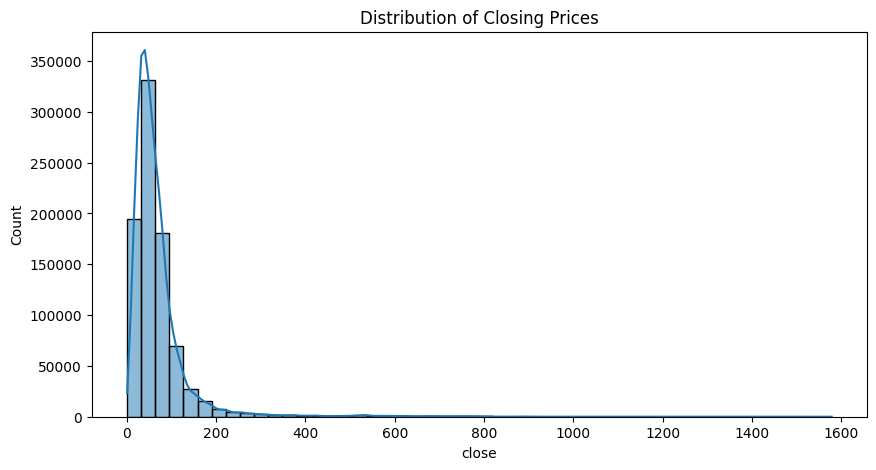

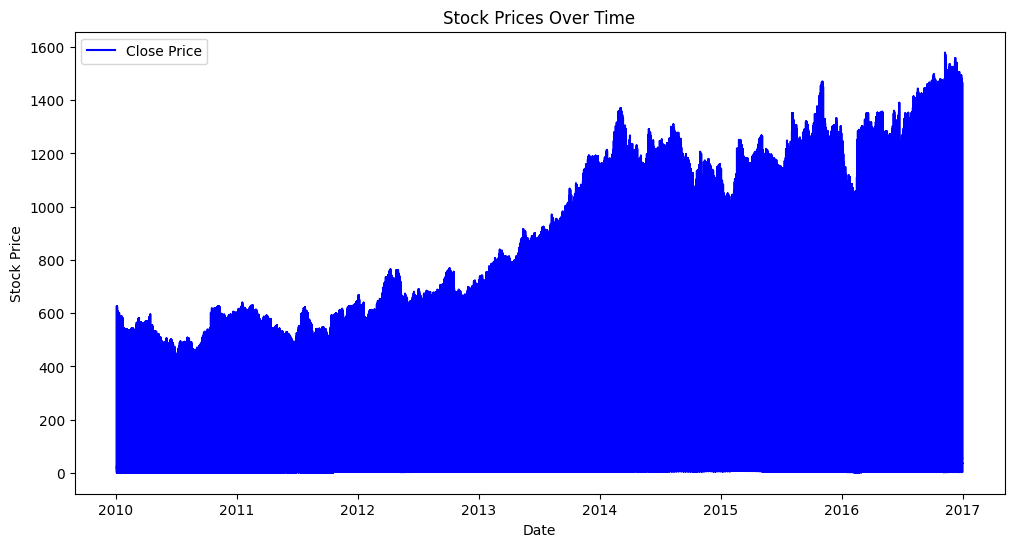

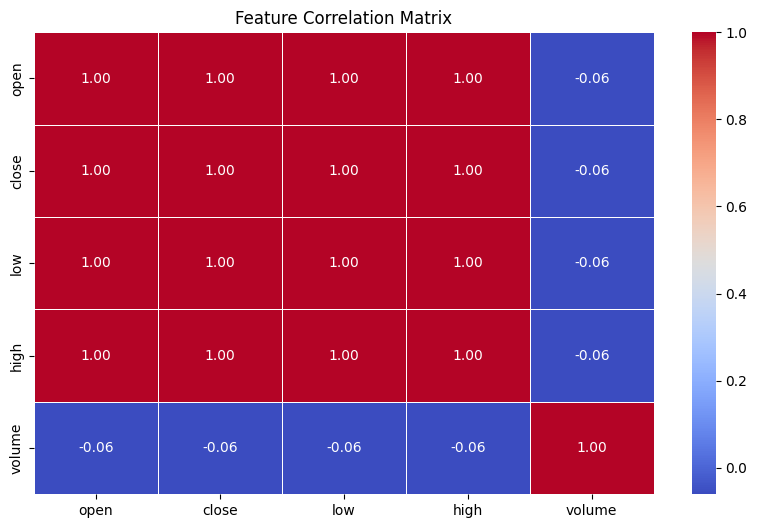

In [1]:
import pandas as pd

# Load dataset (adjust filename if needed)
df = pd.read_csv('prices.csv')

# Display the first few rows
print(df.head())

# Show basic info
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df['close'], bins=50, kde=True)
plt.title("Distribution of Closing Prices")
plt.show()

# Convert date column to datetime (if available)
df['date'] = pd.to_datetime(df['date'], format='mixed', errors='coerce')


# Sort by date
df = df.sort_values(by="date")

# Plot closing prices over time
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['close'], label="Close Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Prices Over Time")
plt.legend()
plt.show()

# Compute correlation matrix
corr = df.select_dtypes(include=['number']).corr()


# Heatmap of correlations
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop non-numeric columns
df = df.drop(columns=['symbol', 'date'])

# Define input features (X) and target variable (y)
X = df.drop(columns=['close']).values  # Use all features except 'close'
y = df['close'].values  # Target variable

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Print shapes to confirm
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

class StockPriceRegressor(nn.Module):
    def __init__(self, input_size):
        super(StockPriceRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Regularization

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  # No activation for regression
        return x

# Initialize model
input_size = X_train.shape[1]  # Number of features
model = StockPriceRegressor(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model summary
print(model)

# Training settings
epochs = 100
batch_size = 64

# Convert dataset into mini-batches
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Reset gradients
        y_pred = model(X_batch)  # Forward pass
        loss = criterion(y_pred, y_batch)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        epoch_loss += loss.item()

    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")
from sklearn.metrics import mean_squared_error

# Set model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    y_pred_train = model(X_train).numpy()
    y_pred_test = model(X_test).numpy()

# Compute MSE
train_mse = mean_squared_error(y_train.numpy(), y_pred_train)
test_mse = mean_squared_error(y_test.numpy(), y_pred_test)

print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")



torch.Size([681011, 4]) torch.Size([681011, 1]) torch.Size([170253, 4]) torch.Size([170253, 1])
StockPriceRegressor(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
Epoch 10/100, Loss: 48.9642
Epoch 20/100, Loss: 33.4382
Epoch 30/100, Loss: 30.0831
Epoch 40/100, Loss: 26.7622
Epoch 50/100, Loss: 26.0536
Epoch 60/100, Loss: 28.3387
Epoch 70/100, Loss: 24.9224
Epoch 80/100, Loss: 23.5001
Epoch 90/100, Loss: 20.3673
Epoch 100/100, Loss: 19.6911
Train MSE: 17828.0254
Test MSE: 17860.7305


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from itertools import product
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import time

# Ensure tensors are on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model with variable hyperparameters
class StockPriceRegressor(nn.Module):
    def __init__(self, input_size, layer_sizes, dropout_rate):
        super(StockPriceRegressor, self).__init__()
        layers = []
        prev_size = input_size

        for size in layer_sizes:
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = size

        layers.append(nn.Linear(prev_size, 1))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Define hyperparameter grid (smaller grid for faster execution)
learning_rates = [0.01]
optimizers = [optim.Adam]
layer_sizes_list = [(128, 64)]  # Reduced number of layers
batch_sizes = [32]  # Reduced batch size
dropout_rates = [0.3]

# Store best model
best_mse = float("inf")
best_params = None

# If X_train and y_train are already PyTorch tensors
X_train_tensor = X_train.to(device).float()
y_train_tensor = y_train.to(device).float().unsqueeze(1).squeeze()
X_test_tensor = X_test.to(device).float()
y_test_tensor = y_test.to(device).float().unsqueeze(1).squeeze()

# Start timing
start_time = time.time()

# Iterate over all hyperparameter combinations
for lr, opt_func, layer_sizes, batch_size, dropout_rate in product(learning_rates, optimizers, layer_sizes_list, batch_sizes, dropout_rates):

    print(f"\n🔍 Testing: LR={lr}, Optimizer={opt_func.__name__}, Layers={layer_sizes}, Batch={batch_size}, Dropout={dropout_rate}")

    # Create model and move it to device
    model = StockPriceRegressor(input_size=X_train_tensor.shape[1], layer_sizes=layer_sizes, dropout_rate=dropout_rate).to(device)
    optimizer = opt_func(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Prepare DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train model (reduced epochs for faster execution)
    epochs = 3  # Reduced epochs for faster training
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor).cpu().numpy()
        y_pred_test_squeezed = np.squeeze(y_pred_test)

    # Check for NaN values and handle them if any
    if np.isnan(y_pred_test_squeezed).any():
        print(f"Warning: NaN values found in predictions for hyperparameters {lr}, {opt_func.__name__}, {layer_sizes}, {batch_size}, {dropout_rate}")
        continue

    # Compute MSE
    try:
        y_test_squeezed = np.squeeze(y_test_tensor.cpu().numpy())
        test_mse = mean_squared_error(y_test_squeezed, y_pred_test_squeezed)
    except ValueError as e:
        print(f"Error while computing MSE: {e}")
        continue

    print(f"🧪 Test MSE: {test_mse:.4f}")

    # Save best model
    if test_mse < best_mse:
        best_mse = test_mse
        best_params = (lr, opt_func, layer_sizes, batch_size, dropout_rate)

# End timing
end_time = time.time()

# Print best hyperparameters
print(f"\n✅ Best Hyperparameters:")
print(f"   - Learning Rate: {best_params[0]}")
print(f"   - Optimizer: {best_params[1].__name__}")
print(f"   - Layers: {best_params[2]}")
print(f"   - Batch Size: {best_params[3]}")
print(f"   - Dropout Rate: {best_params[4]}")
print(f"✅ Best Test MSE: {best_mse:.4f}")

# Print time taken
print(f"\n⏳ Total time taken: {end_time - start_time:.2f} seconds")



🔍 Testing: LR=0.01, Optimizer=Adam, Layers=(128, 64), Batch=32, Dropout=0.3


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧪 Test MSE: 6841.6099

✅ Best Hyperparameters:
   - Learning Rate: 0.01
   - Optimizer: Adam
   - Layers: (128, 64)
   - Batch Size: 32
   - Dropout Rate: 0.3
✅ Best Test MSE: 6841.6099

⏳ Total time taken: 120.15 seconds


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([13, 1, 1])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Train Loss: 7083.8584, Test Loss: 7143.2294
Epoch 2/10, Train Loss: 7034.9119, Test Loss: 7142.8868
Epoch 3/10, Train Loss: 7029.1703, Test Loss: 7140.7595
Epoch 4/10, Train Loss: 7023.5546, Test Loss: 7144.7977
Epoch 5/10, Train Loss: 7017.4507, Test Loss: 7141.1569
Epoch 6/10, Train Loss: 7012.9864, Test Loss: 7142.6331
Epoch 7/10, Train Loss: 7009.0058, Test Loss: 7141.7536
Epoch 8/10, Train Loss: 7004.4642, Test Loss: 7141.1845
Epoch 9/10, Train Loss: 7001.8052, Test Loss: 7140.8665
Epoch 10/10, Train Loss: 7000.8315, Test Loss: 7141.2627


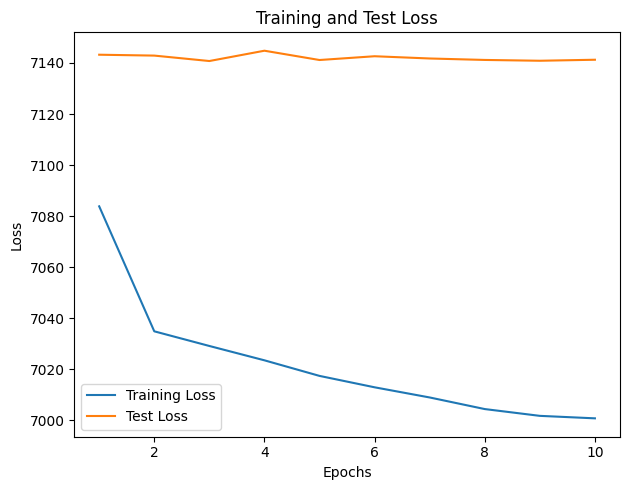

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Assuming you have X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor loaded

# Define your StockPriceRegressor model (replace with your actual model)
class StockPriceRegressor(nn.Module):
    def __init__(self, input_size, layer_sizes=(64, 32), dropout_rate=0.2):
        super(StockPriceRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, layer_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(layer_sizes[0], layer_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(layer_sizes[1], 1)  # Output layer for regression
        )

    def forward(self, x):
        return self.layers(x)


# Hyperparameters (smaller batch size and fewer epochs for memory)
batch_size = 32  # Reduce batch size to reduce memory usage
learning_rate = 0.001 #Reduce learning rate
epochs = 10  # Reduce epochs to reduce training time (can increase later if needed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move data to CPU first, then to device in batches
X_train_tensor = X_train_tensor.cpu()
y_train_tensor = y_train_tensor.cpu()
X_test_tensor = X_test_tensor.cpu()
y_test_tensor = y_test_tensor.cpu()

# Create model and optimizer
model = StockPriceRegressor(input_size=X_train_tensor.shape[1], layer_sizes=(64, 32), dropout_rate=0.2).to(device) # Reduced layer sizes
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Prepare DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for Test Data (crucial for batched evaluation)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # shuffle=False is typical for testing

# Lists to store loss and accuracy for plotting
train_losses = []
test_losses = []


# Training Loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        #Move batch to device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average training loss for the epoch
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluation on test data (Batched Evaluation!)
    model.eval()
    test_epoch_loss = 0.0
    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch = X_test_batch.to(device)
            y_test_batch = y_test_batch.to(device)

            y_pred_test_batch = model(X_test_batch)
            test_loss = criterion(y_pred_test_batch, y_test_batch).item()
            test_epoch_loss += test_loss * X_test_batch.size(0)  # Weighted loss sum

            del X_test_batch, y_test_batch, y_pred_test_batch, test_loss
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # Average test loss for the epoch
        test_loss = test_epoch_loss / len(test_loader.dataset)
        test_losses.append(test_loss)


    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Explicitly delete variables to free memory
    del X_batch, y_batch, y_pred, loss
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

# Plotting the graphs
epochs_range = range(1, epochs + 1)  # Start from 1 for epoch numbers

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.tight_layout()
plt.show()

Training Original Model (No Regularization)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([51, 1, 1])) that is different to the input size (torch.Size([51, 1])). This wi

Epoch 1/10, Train Loss: 7134.6573, Test Loss: 7147.1974
Epoch 2/10, Train Loss: 7053.3303, Test Loss: 7146.8747
Epoch 3/10, Train Loss: 7044.7818, Test Loss: 7147.6333
Epoch 4/10, Train Loss: 7037.9202, Test Loss: 7156.3933
Epoch 5/10, Train Loss: 7032.0936, Test Loss: 7147.6941
Epoch 6/10, Train Loss: 7026.4814, Test Loss: 7155.8833
Epoch 7/10, Train Loss: 7020.3721, Test Loss: 7165.4231
Epoch 8/10, Train Loss: 7016.3533, Test Loss: 7147.8866
Epoch 9/10, Train Loss: 7011.6819, Test Loss: 7147.7920
Epoch 10/10, Train Loss: 7007.8115, Test Loss: 7147.3488

Training L1 Regularized Model
Epoch 1/10, Train Loss: 7113.0965, Test Loss: 7164.7348
Epoch 2/10, Train Loss: 7029.1933, Test Loss: 7153.1986
Epoch 3/10, Train Loss: 7020.9874, Test Loss: 7151.8293
Epoch 4/10, Train Loss: 7014.4695, Test Loss: 7146.9909
Epoch 5/10, Train Loss: 7008.6770, Test Loss: 7148.9569
Epoch 6/10, Train Loss: 7004.2650, Test Loss: 7161.7633
Epoch 7/10, Train Loss: 7000.8925, Test Loss: 7150.7169
Epoch 8/10, Trai

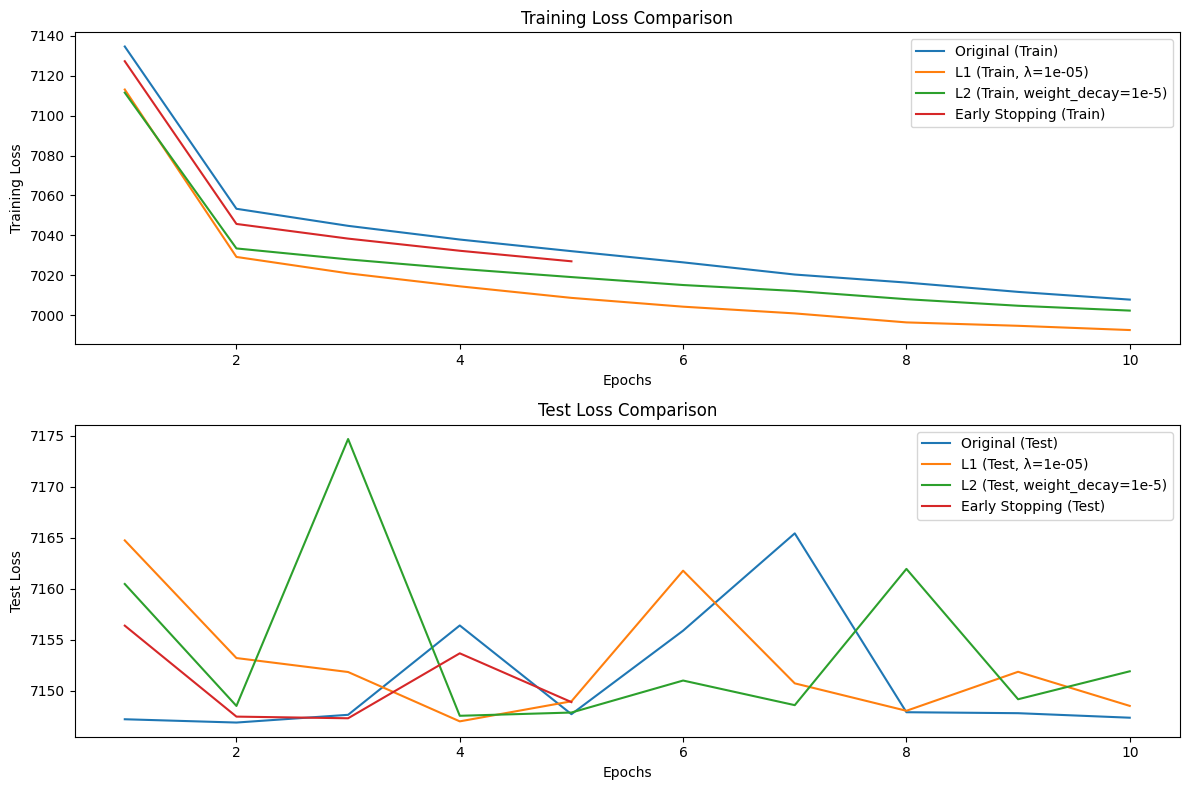


--- Comparison and Interpretation ---
Original Model - Final Test Loss: 7147.3488
L1 Regularized Model - Final Test Loss: 7148.5059
L2 Regularized Model - Final Test Loss: 7151.8995
Early Stopping Model - Final Test Loss: 7148.8793

Interpretations:
- L1 regularization can lead to sparsity (some weights become zero), which can simplify the model.
- L2 regularization penalizes large weights, promoting a smoother model and preventing overfitting.
- Early stopping prevents overfitting by stopping training when the performance on the validation set starts to degrade.
- Compare the training and test loss curves.  A large gap between training and test loss suggests overfitting.
- Regularization techniques are most effective when overfitting is a problem.


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor loaded

# Define your StockPriceRegressor model (replace with your actual model)
class StockPriceRegressor(nn.Module):
    def __init__(self, input_size, layer_sizes=(32, 16), dropout_rate=0.1):  # Reduced layer sizes and dropout
        super(StockPriceRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, layer_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(layer_sizes[0], layer_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(layer_sizes[1], 1)  # Output layer for regression
        )

    def forward(self, x):
        return self.layers(x)


# Hyperparameters (for speed)
batch_size = 64  # Increased batch size (if memory allows)
learning_rate = 0.002  # Slightly higher learning rate
epochs = 10  # Even fewer epochs!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move data to CPU first, then to device in batches
X_train_tensor = X_train_tensor.cpu()
y_train_tensor = y_train_tensor.cpu()
X_test_tensor = X_test_tensor.cpu()
y_test_tensor = y_test_tensor.cpu()

# Prepare DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)  # Added num_workers and pin_memory
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=4, pin_memory=True)  # Increased batch size and added num_workers/pin_memory

# --- Define Training Function ---
def train_model(model, optimizer, criterion, train_loader, test_loader, epochs, device, l1_lambda=0.0, early_stopping_patience=None):
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device, non_blocking=True)  # Added non_blocking
            y_batch = y_batch.to(device, non_blocking=True)  # Added non_blocking

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # L1 Regularization
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_norm

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        # Evaluate on test data
        model.eval()
        test_epoch_loss = 0.0
        with torch.no_grad():
            for X_test_batch, y_test_batch in test_loader:
                X_test_batch = X_test_batch.to(device, non_blocking=True)  # Added non_blocking
                y_test_batch = y_test_batch.to(device, non_blocking=True)  # Added non_blocking

                y_pred_test_batch = model(X_test_batch)
                test_loss = criterion(y_pred_test_batch, y_test_batch).item()
                test_epoch_loss += test_loss * X_test_batch.size(0)

                del X_test_batch, y_test_batch, y_pred_test_batch
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        test_loss = test_epoch_loss / len(test_loader.dataset)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        # Early Stopping
        if early_stopping_patience is not None:
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model_state = model.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve == early_stopping_patience:
                    print("Early stopping triggered!")
                    model.load_state_dict(best_model_state)
                    break
        else:
            best_model_state = model.state_dict()

        del X_batch, y_batch, y_pred, loss
        if torch.cuda.is_available():
          torch.cuda.empty_cache()

    return train_losses, test_losses, model


# --- Training Original Model (No Regularization) ---
print("Training Original Model (No Regularization)")
model_original = StockPriceRegressor(input_size=X_train_tensor.shape[1], layer_sizes=(32, 16), dropout_rate=0.1).to(device)
optimizer_original = optim.Adam(model_original.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
train_losses_original, test_losses_original, model_original = train_model(model_original, optimizer_original, criterion, train_loader, test_loader, epochs, device)


# --- Training L1 Regularized Model ---
print("\nTraining L1 Regularized Model")
l1_lambda = 1e-5
model_l1 = StockPriceRegressor(input_size=X_train_tensor.shape[1], layer_sizes=(32, 16), dropout_rate=0.1).to(device)
optimizer_l1 = optim.Adam(model_l1.parameters(), lr=learning_rate)
train_losses_l1, test_losses_l1, model_l1 = train_model(model_l1, optimizer_l1, criterion, train_loader, test_loader, epochs, device, l1_lambda=l1_lambda)

# --- Training L2 Regularized Model ---
print("\nTraining L2 Regularized Model")
model_l2 = StockPriceRegressor(input_size=X_train_tensor.shape[1], layer_sizes=(32, 16), dropout_rate=0.1).to(device)
optimizer_l2 = optim.Adam(model_l2.parameters(), lr=learning_rate, weight_decay=1e-5)  # L2 regularization using weight_decay
train_losses_l2, test_losses_l2, model_l2 = train_model(model_l2, optimizer_l2, criterion, train_loader, test_loader, epochs, device)

# --- Training Early Stopping Regularized Model ---
print("\nTraining Early Stopping Model")
early_stopping_patience = 2  # Reduced patience further
model_es = StockPriceRegressor(input_size=X_train_tensor.shape[1], layer_sizes=(32, 16), dropout_rate=0.1).to(device)
optimizer_es = optim.Adam(model_es.parameters(), lr=learning_rate)
train_losses_es, test_losses_es, model_es = train_model(model_es, optimizer_es, criterion, train_loader, test_loader, epochs, device, early_stopping_patience=early_stopping_patience)


# --- Plotting Results ---
epochs_range = range(1, len(train_losses_original) + 1) # Adjust to the longest training run

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(epochs_range[:len(train_losses_original)], train_losses_original, label='Original (Train)')
plt.plot(epochs_range[:len(train_losses_l1)], train_losses_l1, label=f'L1 (Train, λ={l1_lambda})')
plt.plot(epochs_range[:len(train_losses_l2)], train_losses_l2, label='L2 (Train, weight_decay=1e-5)')
plt.plot(epochs_range[:len(train_losses_es)], train_losses_es, label='Early Stopping (Train)') #Trim epochs range to match training
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs_range[:len(test_losses_original)], test_losses_original, label='Original (Test)')
plt.plot(epochs_range[:len(test_losses_l1)], test_losses_l1, label=f'L1 (Test, λ={l1_lambda})')
plt.plot(epochs_range[:len(test_losses_l2)], test_losses_l2, label='L2 (Test, weight_decay=1e-5)')
plt.plot(epochs_range[:len(test_losses_es)], test_losses_es, label='Early Stopping (Test)') #Trim epochs range to match training
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('Test Loss Comparison')
plt.legend()


plt.tight_layout()
plt.show()

# --- Comparison and Interpretation ---
print("\n--- Comparison and Interpretation ---")
print(f"Original Model - Final Test Loss: {test_losses_original[-1]:.4f}")
print(f"L1 Regularized Model - Final Test Loss: {test_losses_l1[-1]:.4f}")
print(f"L2 Regularized Model - Final Test Loss: {test_losses_l2[-1]:.4f}")
print(f"Early Stopping Model - Final Test Loss: {test_losses_es[-1]:.4f}")

print("\nInterpretations:")
print("- L1 regularization can lead to sparsity (some weights become zero), which can simplify the model.")
print("- L2 regularization penalizes large weights, promoting a smoother model and preventing overfitting.")
print("- Early stopping prevents overfitting by stopping training when the performance on the validation set starts to degrade.")
print("- Compare the training and test loss curves.  A large gap between training and test loss suggests overfitting.")
print("- Regularization techniques are most effective when overfitting is a problem.")